In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import glob
import cv2
import pickle
import tensorflow as tf

### SegLink Model

In [2]:
from sl_model import SL512, DSODSL512
from sl_utils import PriorUtil
from ssd_data import InputGenerator
from ssd_data import preprocess
from ssd_utils import load_weights

Using TensorFlow backend.


In [ ]:
Model = SL512
#weights_path = './checkpoints/201710242216_sl512_synthtext/weights.002.h5' # SegLink 2
#weights_path = './checkpoints/201710242216_sl512_synthtext/weights.003.h5' # SegLink 2
weights_path = './checkpoints/201711071436_sl512_synthtext/weights.001.h5' # SegLink 3
#weights_path = './checkpoints/201711111814_sl512_synthtext_focal/weights.001.h5'
segment_threshold = 0.71; link_threshold = 0.57
plot_name = 'sl512_crnn_sythtext'

In [3]:
Model = DSODSL512
weights_path = './checkpoints/201711132011_dsodsl512_synthtext/weights.001.h5'
#weights_path = './checkpoints/201806021007_dsodsl512_synthtext/weights.012.h5'
segment_threshold = 0.55; link_threshold = 0.45
plot_name = 'dsodsl512_crnn_sythtext'

In [4]:
sl_graph = tf.Graph()
with sl_graph.as_default():
    sl_session = tf.Session()
    with sl_session.as_default():
        model = Model()
        prior_util = PriorUtil(model)
        load_weights(model, weights_path)

image_size = model.image_size

### CRNN Model

In [5]:
from crnn_model import CRNN
from crnn_utils import alphabet87 as alphabet

input_width = 256
input_height = 32

weights_path = './checkpoints/201806190711_crnn_gru_synthtext/weights.400000.h5'

crnn_graph = tf.Graph()
with crnn_graph.as_default():
    crnn_session = tf.Session()
    with crnn_session.as_default():
        crnn_model = CRNN((input_width, input_height, 1), len(alphabet), prediction_only=True)
        load_weights(crnn_model, weights_path)

layer missing label_input
layer missing input_length
layer missing label_length
layer missing ctc


### Detection real world images

In [6]:
inputs = []
images = []
images_orig = []
data = []

for img_path in glob.glob('data/images/test_images_seglink/*'):
    img = cv2.imread(img_path)
    images_orig.append(np.copy(img))
    inputs.append(preprocess(img, image_size))
    h, w = image_size
    img = cv2.resize(img, (w,h), cv2.INTER_LINEAR).astype('float32') # should we do resizing
    img = img[:, :, (2,1,0)] # BGR to RGB
    img /= 255
    images.append(img)
    
inputs = np.asarray(inputs)

with sl_graph.as_default():
    with sl_session.as_default():
        preds = model.predict(inputs, batch_size=1, verbose=1)

25/25 [==============================] - 3s 132ms/step


In [7]:
%%timeit
for i in range(len(inputs)):
    with sl_graph.as_default():
        with sl_session.as_default():
            preds = model.predict(inputs[i:i+1], batch_size=1, verbose=0)
    #res = prior_util.decode(preds[0], segment_threshold, link_threshold)

1.07 s ± 6.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Detection SynthText

In [ ]:
import pickle
from data_synthtext import GTUtility

file_name = 'gt_util_synthtext_seglink.pkl'
with open(file_name, 'rb') as f:
    gt_util = pickle.load(f)
gt_util_train, gt_util_val = gt_util.split(gt_util, split=0.9)

In [ ]:
idxs, inputs, images, data = gt_util_val.sample_random_batch(batch_size=32, input_size=image_size)

images_orig = [cv2.imread(os.path.join(gt_util_val.image_path, gt_util_val.image_names[idx])) for idx in idxs]

with sl_graph.as_default():
    with sl_session.as_default():
        preds = model.predict(inputs, batch_size=1, verbose=1)

### Recognition

plots/dsodsl512_crnn_sythtext_endtoend_realworld_000.pgf


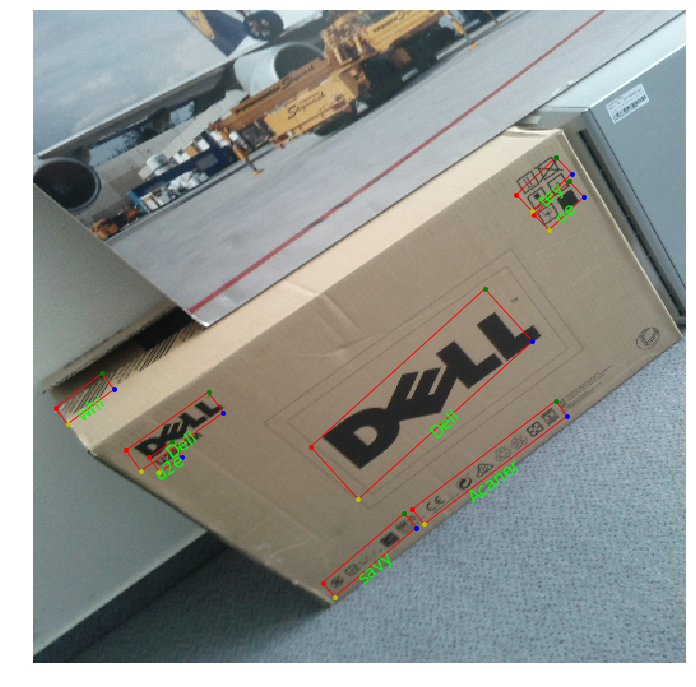

plots/dsodsl512_crnn_sythtext_endtoend_realworld_002.pgf


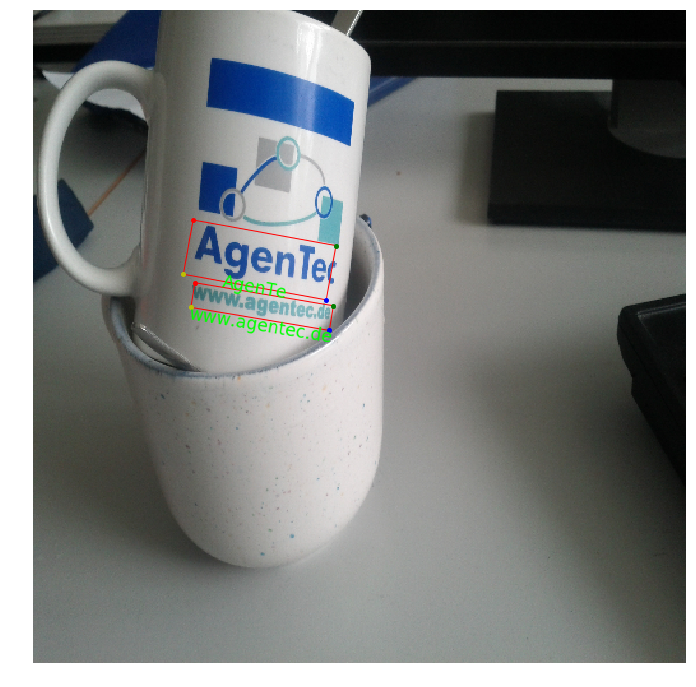

plots/dsodsl512_crnn_sythtext_endtoend_realworld_003.pgf


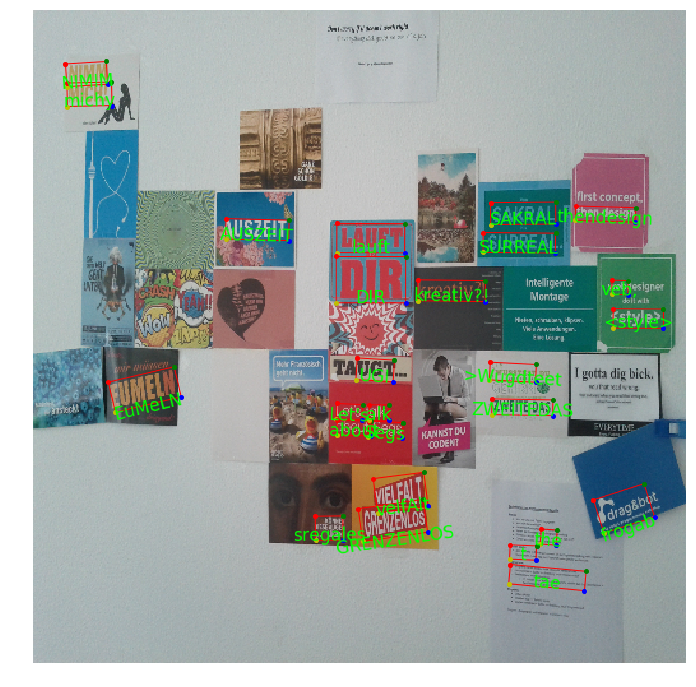

plots/dsodsl512_crnn_sythtext_endtoend_realworld_009.pgf


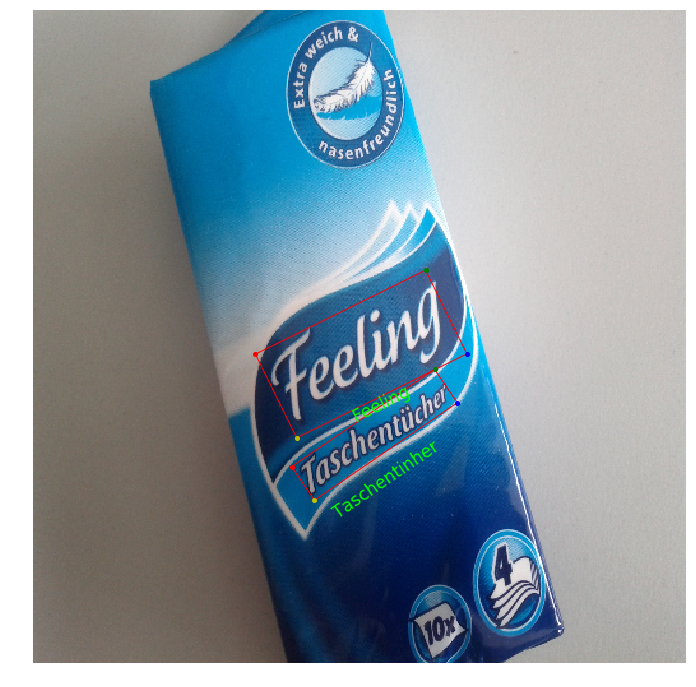

plots/dsodsl512_crnn_sythtext_endtoend_realworld_010.pgf


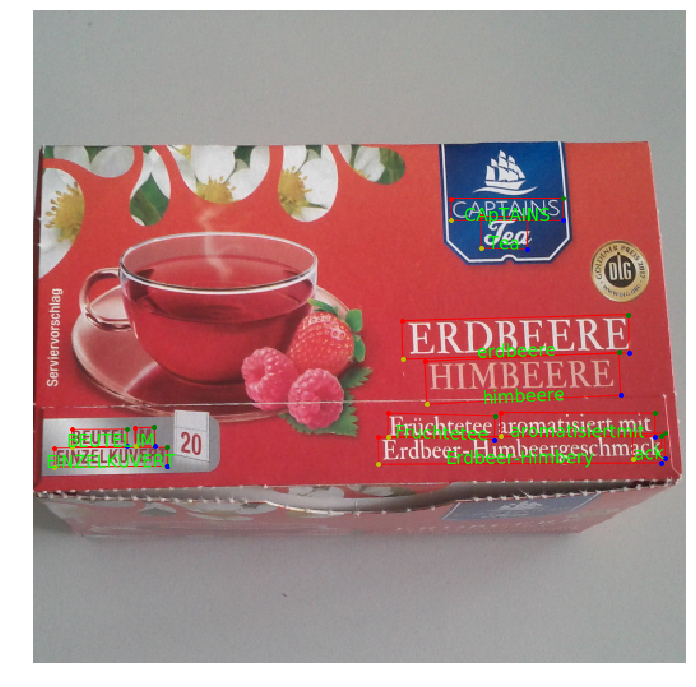

plots/dsodsl512_crnn_sythtext_endtoend_realworld_011.pgf


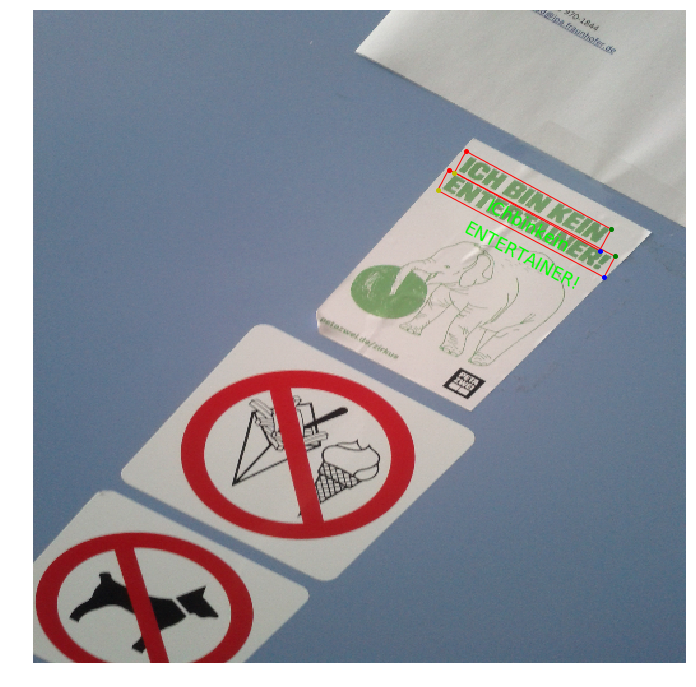

plots/dsodsl512_crnn_sythtext_endtoend_realworld_024.pgf


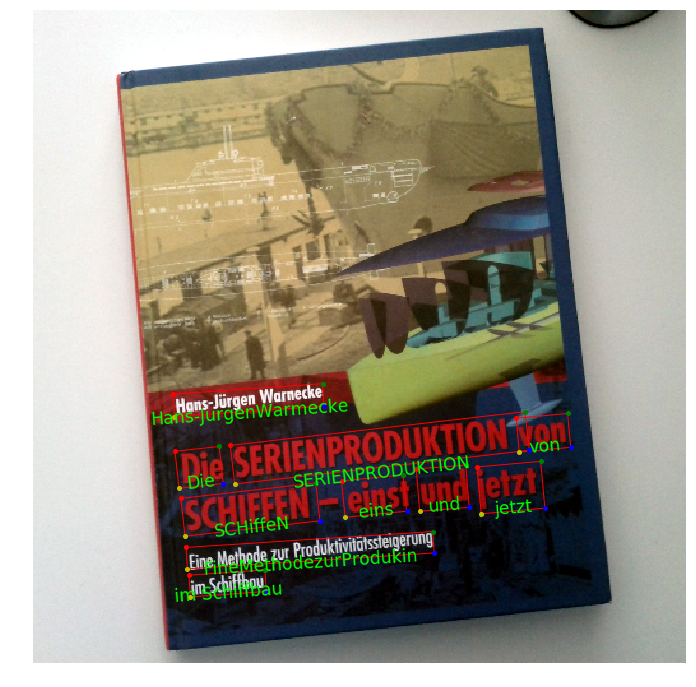

In [8]:
from crnn_data import crop_words
from crnn_utils import decode
from sl_utils import rbox_to_polygon, polygon_to_rbox
from ssd_viz import plot_box, escape_latex

#for k in range(len(preds)):
for k in [0,2,3,9,10,11,24]:
    plt.figure(figsize=[12]*2)
    plt.imshow(images[k])
    res = prior_util.decode(preds[k], segment_threshold, link_threshold)
    
    #print(res.shape)
    
    img = images_orig[k]
    #mean = np.array([104,117,123])
    #img -= mean[np.newaxis, np.newaxis, :]
    rboxes = res[:,:5]
    if len(rboxes) == 0:
        plt.axis('off')
        plt.show()
        continue
        
    bh = rboxes[:,3]
    rboxes[:,2] += bh * 0.1
    rboxes[:,3] += bh * 0.2
    
    boxes = np.asarray([rbox_to_polygon(r) for r in rboxes])
    boxes = np.flip(boxes, axis=1) # TODO: fix order of points, why?
    boxes = np.reshape(boxes, (-1, 8))
    
    boxes_mask_a = np.array([b[2] > b[3] for b in rboxes]) # width > height, in square world
    boxes_mask_b = np.array([not (np.any(b < 0) or np.any(b > 512)) for b in boxes]) # box inside image
    boxes_mask = np.logical_and(boxes_mask_a, boxes_mask_b)
    
    boxes = boxes[boxes_mask]
    rboxes = rboxes[boxes_mask]
    if len(boxes) == 0:
        boxes = np.empty((0,8))
    
    # plot boxes
    for box in boxes:
        c = 'rgby'
        for i in range(4):
            x, y = box[i*2:i*2+2]
            plt.plot(x,y, c[i], marker='o', markersize=4)
        plot_box(box, 'polygon')
    
    words = crop_words(img, boxes/512, input_height, width=input_width, grayscale=True)
    words = np.asarray([w.transpose(1,0,2) for w in words])
    
    if len(words) > 0:
        with crnn_graph.as_default():
            with crnn_session.as_default():
                    res_crnn = crnn_model.predict(words)

    #print('rboxes', len(rboxes), 'words', len(words), 'res_crnn', len(res_crnn))
    for i in range(len(words)):
        chars = [alphabet[c] for c in np.argmax(res_crnn[i], axis=1)]
        
        #gt_str = texts[i]
        res_str = decode(chars)
        
        #ed = editdistance.eval(gt_str, res_str)
        #ed = levenshtein(gt_str, res_str)
        #ed_norm = ed / len(gt_str)
        #mean_ed += ed
        #mean_ed_norm += ed_norm
        
        #print('%-20s %s' % (res_str, ''.join(chars)))
        #print('%s %-20s %0.2f' % (''.join(chars), res_str, res[i,5]))
        
        #print('%-20s %-20s %s %0.2f' % (
        #    gt_str,
        #    res_str,
        #    ''.join(chars),
        #    ed_norm))
        x, y, w, h, theta = rboxes[i]
        
        #res_str = re.sub(r"([#$%&_{}])", r"\\\1" , res_str)
        #print(res_str, '   ', escape_latex(res_str))
        
        
        #plt.text(x+h*np.sin(theta)/2, y+h*np.cos(theta)/2, escape_latex(res_str), rotation=theta/np.pi*180, 
        #         horizontalalignment='center', size='x-large' , color='cyan') # magenta, lime
        plt.text(x+h*np.sin(theta)/2, y+h*np.cos(theta)/2, escape_latex(res_str), rotation=theta/np.pi*180, 
                 horizontalalignment='center', size='xx-large' , color='lime') # magenta, lime
    
    plt.axis('off')
    
    file_name = 'plots/%s_endtoend_realworld_%03i.pgf' % (plot_name, k)
    #plt.savefig(file_name, bbox_inches='tight')
    print(file_name)
    
    plt.show()
    
    if False:
        for i in range(len(words)):
            plt.figure(figsize=[30,0.5])
            plt.imshow(words[i][:,:,0].T, cmap='gray')
            plt.axis('off')
            plt.show()